In [ ]:
!rm -r ML

rm: cannot remove 'ML': No such file or directory


In [ ]:
!git clone https://github.com/fuat-arslan/ML.git

Cloning into 'ML'...
remote: Enumerating objects: 422, done.
remote: Counting objects: 100% (259/259), done.
remote: Compressing objects: 100% (152/152), done.
remote: Total 422 (delta 132), reused 210 (delta 105), pack-reused 163
Receiving objects: 100% (422/422), 6.81 MiB | 22.95 MiB/s, done.
Resolving deltas: 100% (199/199), done.


In [ ]:
#!pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip

In [ ]:
import numpy as np
import pandas as pd
import time
from pandas_profiling import ProfileReport
from matplotlib import pyplot as plt

%matplotlib inline

In [ ]:
data_raw = pd.read_csv("/content/ML/raw_data/archive/sdss-IV-dr16-70k.csv")
data_raw.head()

,objid,ra,dec,psfMag_u,psfMag_g,psfMag_r,psfMag_i,psfMag_z,run,rerun,camcol,field,class,redshift,plate,mjd,fiberid
0,1237663543150183227,339.63895,-0.025366,24.16277,22.12683,20.49114,19.84393,19.39186,4207,301,3,235,GALAXY,0.330663,674,52201,119
1,1237660024494620770,339.14540,-1.176621,24.14103,25.11438,21.40677,19.78998,22.82654,3388,301,1,180,STAR,-0.000051,674,52201,121
2,1237660024494621237,339.09143,-1.226396,22.52415,21.39598,20.74594,20.26970,19.80169,3388,301,1,180,GALAXY,0.185197,674,52201,122
3,1237660024494620813,339.18984,-1.083550,18.44084,17.32474,16.90879,16.75017,16.68101,3388,301,1,180,STAR,-0.000061,674,52201,123
4,1237660024494686312,339.21747,-1.248835,19.55987,19.37768,19.28220,19.27481,19.10290,3388,301,1,181,QSO,0.863151,674,52201,124


In [ ]:
profile = ProfileReport(data_raw)
profile

# PREPROCESSING

In [ ]:
%cd ML

/content/ML


In [ ]:
from Preprocess.Preprocess import pd_np_Converter, OutlierRemoval, MinMax, Encoder, StratifiedTrainValTestSplit
from Preprocess.Feauture_Engineering import PCA

In [ ]:
# rerun is constant, objid is not a feature
data = data_raw.drop(columns=["rerun", "objid"])
# move class to end of data
label = data.pop("class")
data["class"] = label
data.head()

,ra,dec,psfMag_u,psfMag_g,psfMag_r,psfMag_i,psfMag_z,run,camcol,field,redshift,plate,mjd,fiberid,class
0,339.63895,-0.025366,24.16277,22.12683,20.49114,19.84393,19.39186,4207,3,235,0.330663,674,52201,119,GALAXY
1,339.14540,-1.176621,24.14103,25.11438,21.40677,19.78998,22.82654,3388,1,180,-0.000051,674,52201,121,STAR
2,339.09143,-1.226396,22.52415,21.39598,20.74594,20.26970,19.80169,3388,1,180,0.185197,674,52201,122,GALAXY
3,339.18984,-1.083550,18.44084,17.32474,16.90879,16.75017,16.68101,3388,1,180,-0.000061,674,52201,123,STAR
4,339.21747,-1.248835,19.55987,19.37768,19.28220,19.27481,19.10290,3388,1,181,0.863151,674,52201,124,QSO


In [ ]:
# convert data to numpy 
converter = pd_np_Converter(data)
data_np = converter.to_nup()
X = data_np[:, :-1].astype(float)
Y = data_np[:, -1].reshape(-1,1)
X, Y

(array([[ 3.3963895e+02, -2.5366490e-02,  2.4162770e+01, ...,
          6.7400000e+02,  5.2201000e+04,  1.1900000e+02],
        [ 3.3914540e+02, -1.1766212e+00,  2.4141030e+01, ...,
          6.7400000e+02,  5.2201000e+04,  1.2100000e+02],
        [ 3.3909143e+02, -1.2263956e+00,  2.2524150e+01, ...,
          6.7400000e+02,  5.2201000e+04,  1.2200000e+02],
        ...,
        [ 2.3794580e+02, -1.0211284e+00,  2.3042780e+01, ...,
          3.4300000e+02,  5.1692000e+04,  2.8600000e+02],
        [ 2.3795178e+02, -1.0445313e+00,  2.1985720e+01, ...,
          3.4300000e+02,  5.1692000e+04,  2.8700000e+02],
        [ 2.3802744e+02, -8.9427257e-01,  1.9447550e+01, ...,
          3.4300000e+02,  5.1692000e+04,  2.8800000e+02]]), array([['GALAXY'],
        ['STAR'],
        ['GALAXY'],
        ...,
        ['GALAXY'],
        ['GALAXY'],
        ['QSO']], dtype=object))

In [ ]:
# then apply outlier removal and standard normalized
OutRemove = OutlierRemoval(X, Y, 3) # 3 denotes threshold value
X_clean, Y_clean = OutRemove.fast()
X_clean.shape, Y_clean.shape

((66329, 14), (66329, 1))

In [ ]:
# since psf_Mag's are highly linearly correlated, they are decorrelated using PCA
# we are not decreasing the dimension!!
pca = PCA()
decorrelated_psf = pca.fast(X_clean[:, 2:7], 5)
decorrelated_psf  
# decorrelated values are very small, since all other features are between -3,3;
# decorrelated values are linearly mapped to -3,3 range back 

array([[-0.01095209, -0.00501874, -0.00076389, -0.00051687, -0.00017521],
       [-0.02288711, -0.00089556,  0.00095841, -0.01047953,  0.00600617],
       [-0.00901848,  0.00166024, -0.00029926,  0.00044585, -0.00022209],
       ...,
       [-0.00487142, -0.00426251,  0.00098315, -0.00143684, -0.00023805],
       [ 0.00376348, -0.00290885, -0.00032283,  0.00010291, -0.00011273],
       [ 0.0110536 ,  0.00388839,  0.00174748, -0.00012445, -0.00072617]])

In [ ]:
# map decorrleted_psf to -3,3
mapper = MinMax(low = -3, high = 3)
psf = mapper.fast(decorrelated_psf)
psf

array([[-1.00659912, -0.44134628, -0.67973026,  0.03733094, -0.39212334],
       [-1.74732434,  0.02172388, -0.43924667, -1.29560489,  0.30016497],
       [-0.8865931 ,  0.30876363, -0.6148543 ,  0.16613592, -0.39737398],
       ...,
       [-0.6292132 , -0.35641448, -0.43579097, -0.08575483, -0.39916092],
       [-0.09330395, -0.20438616, -0.61814465,  0.12025261, -0.38512614],
       [ 0.35914438,  0.55900553, -0.32906811,  0.08983296, -0.4538284 ]])

In [ ]:
# change old values by new decorrelated values
X_clean[:, 2:7] = psf

In [ ]:
# label encoder
encode1 = Encoder(one_hot = False)
Y = encode1.fast(Y_clean)
Y.shape

(66329, 1)

# Train Validation Test Split

In [ ]:
splitter = StratifiedTrainValTestSplit(X_clean, Y, train_size=0.8, 
                                       val_size=0.1, test_size=0.1, 
                                       stratify=True, random_state=1)

X_train, X_val, X_test, Y_train, Y_val, Y_test = splitter.split()
X_train.shape, X_val.shape, X_test.shape, Y_train.shape, Y_val.shape, Y_test.shape

((53062, 14), (6631, 14), (6631, 14), (53062, 1), (6631, 1), (6631, 1))

# k-NN

In [ ]:
from Models.KNN import KNN
from Metrics.Metrics import kFold, Evaluator 

In [ ]:
X_cv = np.vstack((X_train, X_val))
Y_cv = np.vstack((Y_train, Y_val))
X_cv.shape, Y_cv.shape

((59693, 14), (59693, 1))

In [ ]:
# argmax_flag denotes labels are categoric, not one_hot
k_list = [5,7,9,11,13,15,17,19,21]
acc_dict = {}
for k in k_list:
    t1 = time.time()
    print("Cross validation is being done for k="+str(k))
    cv_k_NN = kFold(argmax_flag = False)
    k_NN_model = KNN(num_neig = k, metric = "euclidian", weighted = True)
    avg_loss, acc_list = cv_k_NN.eval(k_NN_model, X_cv, Y_cv, None, 5)
    acc_dict[str("k = ")+str(k)] = acc_list
    t2 = time.time()
    print(f"Elapsed time for CV when k = {k} is {np.round(t2-t1,2)} secs\n")

Cross validation is being done for k=5
Accuracy of folds respectively : [93. 93. 93. 93. 91.]
Elapsed time for CV when k = 5 is 664.83 secs

Cross validation is being done for k=7
Accuracy of folds respectively : [92. 93. 93. 93. 91.]
Elapsed time for CV when k = 7 is 661.66 secs

Cross validation is being done for k=9
Accuracy of folds respectively : [92. 93. 93. 92. 91.]
Elapsed time for CV when k = 9 is 661.94 secs

Cross validation is being done for k=11
Accuracy of folds respectively : [92. 92. 92. 92. 90.]
Elapsed time for CV when k = 11 is 660.31 secs

Cross validation is being done for k=13
Accuracy of folds respectively : [92. 92. 92. 92. 90.]
Elapsed time for CV when k = 13 is 664.63 secs

Cross validation is being done for k=15
Accuracy of folds respectively : [92. 92. 92. 91. 90.]
Elapsed time for CV when k = 15 is 665.97 secs

Cross validation is being done for k=17
Accuracy of folds respectively : [91. 92. 92. 91. 90.]
Elapsed time for CV when k = 17 is 657.98 secs

Cross

In [ ]:
avg_dict = {key: np.sum(value) / len(value) for key, value in acc_dict.items()}
avg_dict

{'k = 5': 0.9254649019936337,
 'k = 7': 0.9226336069693415,
 'k = 9': 0.9210085441447479,
 'k = 11': 0.91867984587033,
 'k = 13': 0.9162338750209417,
 'k = 15': 0.9136873848215782,
 'k = 17': 0.9117942703970515,
 'k = 19': 0.9100854414474787,
 'k = 21': 0.9084268721728932}

Text(0.5, 1.0, 'Accuracy vs k Plot')

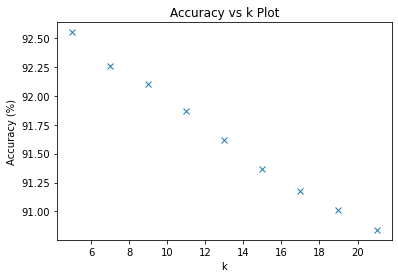

In [ ]:
avg_acc = 100*np.round(list(avg_dict.values()),4)
plt.plot(k_list, avg_acc, "x")
plt.xlabel("k")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy vs k Plot")

In [ ]:
# for unweighted k-NN
k_list = [5,7,9,11,13,15,17,19,21]
acc_dict = {}
for k in k_list:
    t1 = time.time()
    print("Cross validation is being done for k="+str(k))
    cv_k_NN = kFold(argmax_flag = False)
    k_NN_model = KNN(num_neig = k, metric = "euclidian", weighted = False)
    avg_loss, acc_list = cv_k_NN.eval(k_NN_model, X_cv, Y_cv, None, 5)
    acc_dict[str("k = ")+str(k)] = acc_list
    t2 = time.time()
    print(f"Elapsed time for CV when k = {k} is {np.round(t2-t1,2)} secs\n")

**Testin k-NN on Validated Parameters**

In [ ]:
# we found that the most optimal k = 5
optimal_k_NN = KNN(num_neig = 5, metric = "euclidian", weighted = True)
pred_k_NN = optimal_k_NN.learn(X_train, Y_train).predict(X_test)
eval = Evaluator(pred_k_NN, Y_test, label_dict = {"Galaxy": 0, "QSO": 1, "Stars": 2})

Accuracy:  0.89


(0.8856884331171769, array([[0.96294772, 0.89274809, 0.9265201 ],
        [0.66108787, 0.87052342, 0.75148633],
        [0.67876448, 0.85505837, 0.75678003]]))

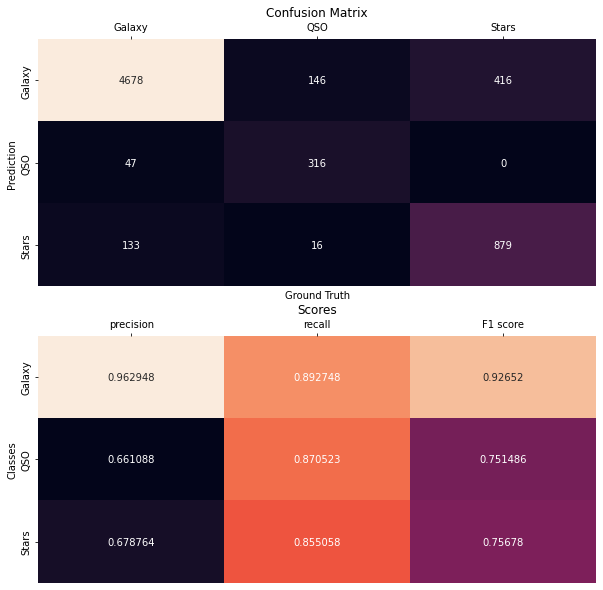

In [ ]:
_,_ = eval.scores()

# Neural Network

In [ ]:
from Models.NeuralNetwork.Layers import Dense
from Models.NeuralNetwork.Optimizer import Optimizer
from Models.NeuralNetwork.Trainer import NeuralNetwork

In [ ]:
# label encoder for one hot
encoder = Encoder(one_hot = True)
Y2 = encoder.fast(Y_clean)
Y2.shape

(66329, 3)

In [ ]:
splitter = StratifiedTrainValTestSplit(X_clean, Y2, train_size=0.8, 
                                       val_size=0.1, test_size=0.1, 
                                       stratify=True, random_state=1)

X_train, X_val, X_test, Y_train, Y_val, Y_test = splitter.split()
X_train.shape, X_val.shape, X_test.shape, Y_train.shape, Y_val.shape, Y_test.shape

((53062, 14), (6631, 14), (6631, 14), (53062, 3), (6631, 3), (6631, 3))

In [ ]:
X_cv = np.vstack((X_train, X_val))
Y_cv = np.vstack((Y_train, Y_val))
X_cv.shape, Y_cv.shape

((59693, 14), (59693, 3))

There will be 81 combinations
Cost after epoch 0: 0.670810
Cost after epoch 10: 0.133488
Cost after epoch 20: 0.105775
Cost after epoch 0: 0.667066
Cost after epoch 10: 0.132314
Cost after epoch 20: 0.104498
Cost after epoch 0: 0.670424
Cost after epoch 10: 0.133437
Cost after epoch 20: 0.105693
Cost after epoch 0: 0.672221
Cost after epoch 10: 0.134347
Cost after epoch 20: 0.106374
Cost after epoch 0: 0.685321
Cost after epoch 10: 0.131701
Cost after epoch 20: 0.103533
Average loss: 0.1087
Accuracy of folds respectively : [97. 97. 97. 97. 97.]
Elapsed time for 0th parameter set is 93.08 secs
Cost after epoch 0: 0.745766
Cost after epoch 10: 0.167995
Cost after epoch 20: 0.124448
Cost after epoch 0: 0.748086
Cost after epoch 10: 0.161947
Cost after epoch 20: 0.120772
Cost after epoch 0: 0.749659
Cost after epoch 10: 0.165449
Cost after epoch 20: 0.121612
Cost after epoch 0: 0.749756
Cost after epoch 10: 0.165639
Cost after epoch 20: 0.123359
Cost after epoch 0: 0.757934
Cost after epoc

/content/ML/utils.py:33: RuntimeWarning: invalid value encountered in true_divide
  return e_x / e_x.sum(axis=0)


Cost after epoch 20: nan
Cost after epoch 0: nan
Cost after epoch 10: nan
Cost after epoch 20: nan
Cost after epoch 0: nan
Cost after epoch 10: nan
Cost after epoch 20: nan
Cost after epoch 0: nan
Cost after epoch 10: nan
Cost after epoch 20: nan
Cost after epoch 0: nan
Cost after epoch 10: nan
Cost after epoch 20: nan
Average loss: nan
Accuracy of folds respectively : [72. 73. 74. 74. 73.]
Elapsed time for 6th parameter set is 85.3 secs
Cost after epoch 0: 0.176391
Cost after epoch 10: 0.086292
Cost after epoch 20: 0.082342
Cost after epoch 0: 0.174601
Cost after epoch 10: 0.089656
Cost after epoch 20: 0.082284
Cost after epoch 0: 0.178535
Cost after epoch 10: 0.088365
Cost after epoch 20: 0.081008
Cost after epoch 0: 0.173674
Cost after epoch 10: 0.089291
Cost after epoch 20: 0.083623
Cost after epoch 0: 0.173251
Cost after epoch 10: 0.088489
Cost after epoch 20: 0.082554
Average loss: 0.0878
Accuracy of folds respectively : [98. 97. 98. 98. 97.]
Elapsed time for 7th parameter set is

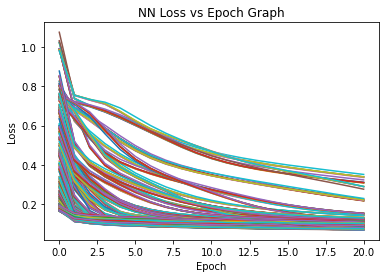

In [ ]:
# define grid search on the parameters, there are 64 possibilities
param_grid = {}
param_grid["learning_rates"] = [0.0001, 0.001, 0.01]
param_grid["batch_sizes"] = [16, 32, 64]
param_grid["layer_neuron"] = [ [14, 32, 8, 3], [14, 16, 32, 3], [14, 64, 32, 8, 3] ]
param_grid["activations"] = ["relu", "sigmoid", "tanh"]

param_combinations = np.array(np.meshgrid(*param_grid.values())).T.reshape(-1, len(param_grid))

scores = {}

print(f"There will be {param_combinations.shape[0]} combinations")
for j, params in enumerate(param_combinations):
        t1 = time.time()
        params_dict = {key: value for key, value in zip(param_grid.keys(), params)}

        # creating the NN model
        layers = []
        for i in range(1, len(params_dict["layer_neuron"])-1):
            layers.append(Dense(params_dict["layer_neuron"][i-1], params_dict["layer_neuron"][i], activation = params_dict["activations"]))
        layers.append(Dense(params_dict["layer_neuron"][-2], params_dict["layer_neuron"][-1], activation = "stable_softmax"))

        model_NN = NeuralNetwork(layers, "CrossEntopy")
        adam = Optimizer("adam", params_dict["learning_rates"], None, 0.9, 0.99)

        # creating kFold
        cv_NN = kFold(True)
        avg_loss, acc_list = cv_NN.eval(model_NN, X_cv, Y_cv, 
                                        "CrossEntropy", 
                                        5,
                                        adam,
                                        21,
                                        params_dict["batch_sizes"])

        # Store the mean score for this combination of hyperparameters
        scores[str(j)] = np.mean(acc_list)

        t2 = time.time()
        print(f"Elapsed time for {j}th parameter set is {np.round(t2-t1,2)} secs")

In [ ]:
# Find the index of the best combination of hyperparameters
print(scores)
max_idx = max(scores, key=scores.get)
params = param_combinations[int(max_idx)]
optimal_dict = {key: value for key, value in zip(param_grid.keys(), params)}
print(optimal_dict)

{'0': 0.9705813369073546, '1': 0.9651867984587031, '2': 0.9644664097838834, '3': 0.9757413302060647, '4': 0.97543977215614, '5': 0.9746356173563411, '6': 0.7325347629418664, '7': 0.9754565253811359, '8': 0.9739989948065002, '9': 0.9690902998827274, '10': 0.9680515999329872, '11': 0.9582007036354498, '12': 0.976059641480985, '13': 0.976076394705981, '14': 0.9753057463561736, '15': 0.7325347629418664, '16': 0.9761266543809682, '17': 0.9746021109063495, '18': 0.9740492544814877, '19': 0.9727257497068186, '20': 0.9700619869324845, '21': 0.975707823756073, '22': 0.9750376947562407, '23': 0.9746858770313285, '24': 0.7325347629418664, '25': 0.9744513318813871, '26': 0.9739989948065002, '27': 0.964583682358854, '28': 0.9303903501424025, '29': 0.8823085944044229, '30': 0.976428212430893, '31': 0.976327693080918, '32': 0.975087954431228, '33': 0.9754732786061318, '34': 0.9763109398559223, '35': 0.9754230189311442, '36': 0.9629418663092647, '37': 0.9269391857932652, '38': 0.8902998827274251, '39'

In [ ]:
scores = {'0': 0.9705813369073546, '1': 0.9651867984587031, '2': 0.9644664097838834, '3': 0.9757413302060647, '4': 0.97543977215614, '5': 0.9746356173563411, '6': 0.7325347629418664, '7': 0.9754565253811359, '8': 0.9739989948065002, '9': 0.9690902998827274, '10': 0.9680515999329872, '11': 0.9582007036354498, '12': 0.976059641480985, '13': 0.976076394705981, '14': 0.9753057463561736, '15': 0.7325347629418664, '16': 0.9761266543809682, '17': 0.9746021109063495, '18': 0.9740492544814877, '19': 0.9727257497068186, '20': 0.9700619869324845, '21': 0.975707823756073, '22': 0.9750376947562407, '23': 0.9746858770313285, '24': 0.7325347629418664, '25': 0.9744513318813871, '26': 0.9739989948065002, '27': 0.964583682358854, '28': 0.9303903501424025, '29': 0.8823085944044229, '30': 0.976428212430893, '31': 0.976327693080918, '32': 0.975087954431228, '33': 0.9754732786061318, '34': 0.9763109398559223, '35': 0.9754230189311442, '36': 0.9629418663092647, '37': 0.9269391857932652, '38': 0.8902998827274251, '39': 0.9760261350309936, '40': 0.975004188306249, '41': 0.9749204221812701, '42': 0.9740660077064834, '43': 0.9701289998324677, '44': 0.9749874350812531, '45': 0.9710336739822416, '46': 0.9686547160328363, '47': 0.9029318143742671, '48': 0.9751047076562237, '49': 0.9756073044060981, '50': 0.9753224995811693, '51': 0.9749706818562573, '52': 0.9765957446808511, '53': 0.9748366560562909, '54': 0.9722734126319317, '55': 0.9692745853576813, '56': 0.9685541966828615, '57': 0.9773663930306583, '58': 0.9758250963310438, '59': 0.9758418495560395, '60': 0.9728262690567935, '61': 0.9744680851063829, '62': 0.9752387334561903, '63': 0.9721393868319652, '64': 0.968956274082761, '65': 0.9641648517339588, '66': 0.9759591221310103, '67': 0.9753392528061651, '68': 0.9750209415312447, '69': 0.9740157480314962, '70': 0.9704305578823924, '71': 0.9732786061316805, '72': 0.9755067850561232, '73': 0.9737309432065674, '74': 0.9724241916568939, '75': 0.9757413302060647, '76': 0.9753224995811693, '77': 0.9715697771821075, '78': 0.9689730273077568, '79': 0.9700284804824928, '80': 0.972507957781873}

In [ ]:
# Sort the scores dictionary by value to see how much better the best model
sorted_scores = {k: v for k, v in sorted(scores.items(), key=lambda item: item[1], reverse = True)}
sorted_scores

**Testing Neural Network on Validated Parameters**

Cost after epoch 0: 0.254465
Cost after epoch 10: 0.079713
Cost after epoch 20: 0.073196
Cost after epoch 30: 0.070720
Cost after epoch 40: 0.068140
Cost after epoch 50: 0.066697
Cost after epoch 60: 0.065265
Cost after epoch 70: 0.064026
Cost after epoch 80: 0.062943


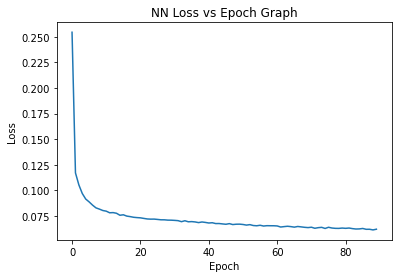

In [ ]:
layers = [Dense(14, 32, activation = "tanh"),
          Dense(32, 8, activation = "tanh"),
          Dense(8, 3, activation = "softmax")]

model_NN = NeuralNetwork(layers, "CrossEntopy")
adam = Optimizer("adam", 0.001, None, 0.9, 0.99)

model_NN.learn(X_train, Y_train, optimizer = adam, max_epoch = 90, batch_size = 16)

In [ ]:
pred = model_NN.predict(X_test)

Accuracy:  0.96


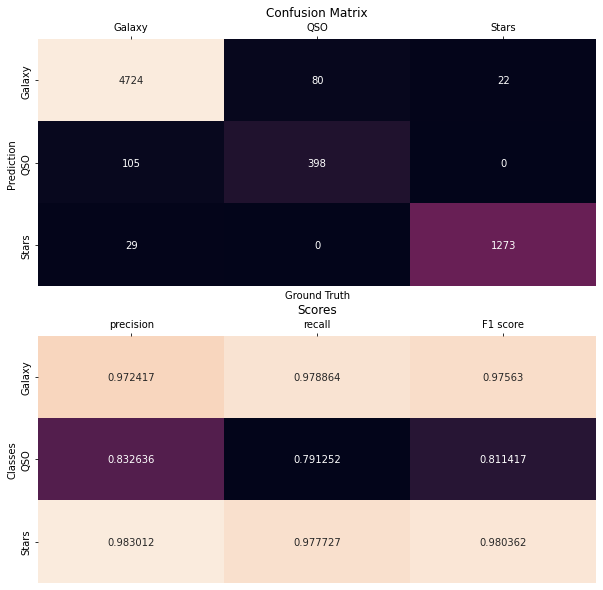

In [ ]:
evaluate = Evaluator(np.argmax(pred.T, axis = 1), np.argmax(Y_test, axis = 1), 
                     label_dict = {"Galaxy": 0, "QSO": 1, "Stars": 2})
_,_ = evaluate.scores()

In [ ]:
a = 1/3*(0.972417+0.832636+0.983012)
b = 1/3*(0.978854+0.791252+0.977727)
c = 1/3*(0.97563+0.811417+0.980362)
a,b,c

(0.9293549999999999, 0.9159443333333332, 0.9224696666666665)

# XGBoost 

In [ ]:
from Models.XGBoost import XGB
xgb = XGB.XGBoost_Classifier(n_trees = 10, max_depth = 3, min_leaf_size = 400, 
                             learning_rate = 0.1, gamma = 1, lmb=1, col_num = 4)

In [ ]:
t1 = time.time()
xgb.learn(X_train, Y_train)
t2 = time.time()
print(t2-t1)

100%|██████████| 10/10 [1:27:24<00:00, 524.47s/it]

5244.714167833328


Accuracy:  0.97


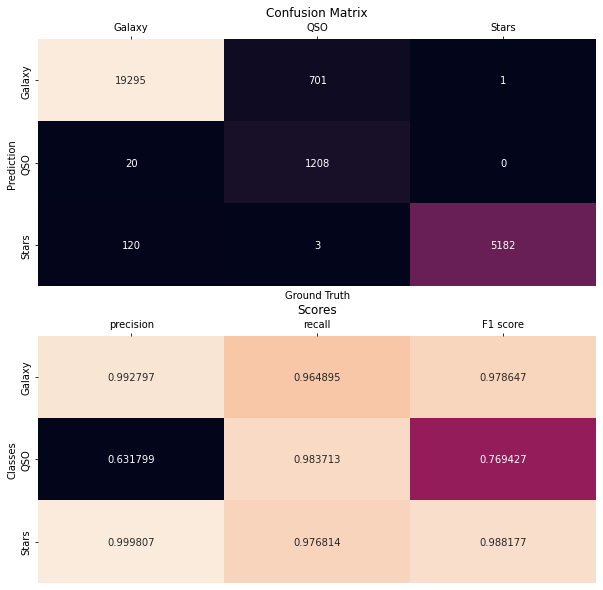

In [ ]:
pred_train = xgb.predict(X_train)
evaluate_train = Evaluator(pred_train, np.argmax(Y_train, axis = 1), 
                     label_dict = {"Galaxy": 0, "QSO": 1, "Stars": 2})
_,_ = evaluate_train.scores()

Accuracy:  0.96


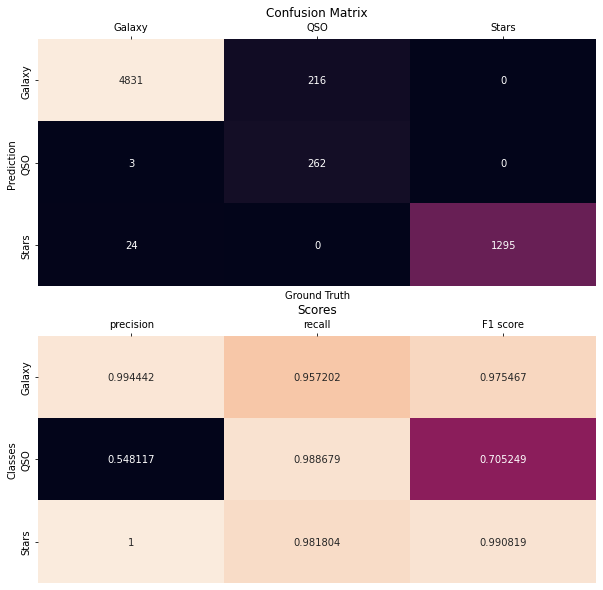

In [ ]:
pred_val = xgb.predict(X_test)
evaluate_val = Evaluator(pred_val, np.argmax(Y_test, axis = 1), 
                     label_dict = {"Galaxy": 0, "QSO": 1, "Stars": 2})
_,_ = evaluate_val.scores()